In this notebook I am going to test data storing formats supported by Pandas library. Goal is to compare saving and loading times as well as data compression.

More about Pandas IO Tools can be found under following link:
https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html

### Import

In [1]:
import os
import re
import time
import inspect

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Prerequisites

In [2]:
# Html
print("Html")
!pip install lxml
!pip install html5lib
!pip install BeautifulSoup4

# Hdf5
print("\nHdf5")
!pip install tables

# Excel
print("\nExcel")
!pip install xlwt
!pip install xlrd

# Feather
print("\nFeather")
!pip install feather-format

# Msgpack
print("\nMsgpack")
!pip install msgpack
!pip install blosc

# Parquet
print("\nParquet")
!pip install python-snappy
!pip install pyarrow
!pip install fastparquet

# Sql
print("\nSql")
!pip install sqlalchemy

Html
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

Hdf5
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

Excel
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

Feather
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrad

### Storage

In [3]:
test_cases = []

### Code

In [4]:
def generate_large_dataframe(row_num, dtypes=[]):
    return pd.DataFrame({
        (str(t) + "_col"): np.random.uniform(-100, 100, row_num).astype(t) for t in dtypes
    })

class DataStorageFormatTest:
    BASE_NAME = "test|"
    
    def __init__(self, extension, save_func, save_args, load_func, load_args):
        self.extension = extension
        self.save_func = save_func
        self.save_args = save_args
        self.load_func = load_func
        self.load_args = load_args
        
        self.save_time = -1
        self.load_time = -1
        self.file_size = -1
        
        self.save_tag = None
        self.load_tag = None
        
    def _build_filename(self, arg_dict):
        args_name_part = "_".join(
            ["{}={}".format(a,v) for a,v in arg_dict.items() if a != "con"]) if arg_dict else ""
        return self.BASE_NAME + args_name_part + "." + self.extension
    
    @staticmethod
    def _get_save_name_argument(func):
        args = inspect.getfullargspec(func).args
        return args[1] if args else None
    
    @staticmethod
    def _get_load_name_argument(func):
        args = inspect.getfullargspec(func).args
        return args[0] if args else None
        
    def test_save(self, df):
        extracted_save_func = getattr(df, self.save_func)
        filename = self._build_filename(self.save_args)
        save_name_argument = self._get_save_name_argument(extracted_save_func)
        
        self.save_args[save_name_argument] = filename
        print("Saving:", self.save_args)
        
        start_time = time.time()
        if save_name_argument is None:
            extracted_save_func(filename)
        else:
            extracted_save_func(**self.save_args)
        self.save_time = time.time() - start_time
        
        self.save_tag = filename
        del self.save_args[save_name_argument]
    
    def test_load(self):
        extracted_load_func = getattr(pd, self.load_func)
        filename = self._build_filename(self.save_args)
        load_name_argument = self._get_load_name_argument(extracted_load_func)
        
        self.load_args[load_name_argument] = filename
        print("Loading:", self.load_args)
        
        start_time = time.time()
        if load_name_argument is None:
            df_loaded = extracted_load_func(filename)
        else:
            df_loaded = extracted_load_func(**self.load_args)
        self.load_time = time.time() - start_time
        
        self.load_tag = self._build_filename(self.load_args)
        del self.load_args[load_name_argument]
        
        return df_loaded
        
    def test_filesize(self):
        filename = self._build_filename(self.save_args)
        self.file_size = os.path.getsize(filename) / (1024**2)
        
    def compare_dfs(self, df_source, df_loaded):
        print()
        
        same_types = type(df_source) == type(df_loaded)
        print("Same types:".ljust(30), "{}".format(same_types))
        
        if not same_types and isinstance(df_loaded, list):
            print("\t- Dataframe was loaded as list. Extracting it.")
            df_loaded = df_loaded[0]
            same_types = type(df_source) == type(df_loaded)
            
        if same_types:
        
            # Workaround for excel bugged index=False 
            # and other methods not supporting **kwargs like stata
            if df_loaded.shape[1] > df_source.shape[1]:
                df_loaded = df_loaded[df_loaded.columns[1:]]
            
            are_col_names_the_same = all(df_source.columns.values == df_loaded.columns.values)
            print("Same column names:".ljust(30), "{}".format(are_col_names_the_same))
            if not are_col_names_the_same:
                for col_source, col_loaded in zip(df_source.columns, df_loaded.columns):
                    if col_source != col_loaded:
                        print("\t- Expected/Loaded column name:", 
                              "{}".format(col_source).ljust(20), 
                              "->",
                              "{}".format(col_loaded))
            
            are_indices_in_same_order = all(df_source.index.values == df_loaded.index.values)
            print("Same order of index:".ljust(30), "{}".format(are_indices_in_same_order))

            are_dtypes_the_same = all(df_source.dtypes.values == df_loaded.dtypes.values)
            print("Same datatypes:".ljust(30), "{}".format(are_dtypes_the_same))

            if not are_dtypes_the_same:
                for dtype_s, dtype_l in zip(df_source.dtypes.values, df_loaded.dtypes.values):
                    if dtype_s != dtype_l:
                        print("\t- Expected/Loaded dtype:", 
                              "{}".format(dtype_s).ljust(15), 
                              "->",
                              "{}".format(dtype_l))
        else:
            print("ERROR: Unable to compare loaded data.")

### Generating Large DataFrame

In [5]:
df_large_dataframe = generate_large_dataframe(
    3000000, dtypes=[str, bool, 'datetime64[ms]', np.int32, np.float32, np.int64, np.float64])

In [6]:
df_large_dataframe.head(8)

,<class 'str'>_col,<class 'bool'>_col,datetime64[ms]_col,<class 'numpy.int32'>_col,<class 'numpy.float32'>_col,<class 'numpy.int64'>_col,<class 'numpy.float64'>_col
0,83.39130199862308,True,1970-01-01 00:00:00.014,71,-61.537670,-17,72.545802
1,79.01802521324791,True,1969-12-31 23:59:59.953,69,85.571632,-60,-84.042489
2,-6.73162784062022,True,1970-01-01 00:00:00.037,73,-97.621948,-62,-31.298302
3,4.462569696525762,True,1970-01-01 00:00:00.009,84,9.109997,30,-25.867295
4,67.23674004688417,True,1969-12-31 23:59:59.902,7,42.614281,-50,84.203620
5,-26.97640458604586,True,1969-12-31 23:59:59.966,-66,-94.592140,-39,-24.654334
6,89.15926684845013,True,1970-01-01 00:00:00.034,-48,40.185963,-6,-34.367433
7,60.76654916936144,True,1970-01-01 00:00:00.003,-33,8.894307,24,-98.618012


In [7]:
df_large_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 7 columns):
<class 'str'>_col              object
<class 'bool'>_col             bool
datetime64[ms]_col             datetime64[ns]
<class 'numpy.int32'>_col      int32
<class 'numpy.float32'>_col    float32
<class 'numpy.int64'>_col      int64
<class 'numpy.float64'>_col    float64
dtypes: bool(1), datetime64[ns](1), float32(1), float64(1), int32(1), int64(1), object(1)
memory usage: 117.3+ MB


### Preparing tests

- csv

In [8]:
test_cases.append(DataStorageFormatTest("csv", "to_csv", {"index": False}, "read_csv", {}))

- json

In [9]:
test_cases.append(DataStorageFormatTest("json", "to_json", {}, "read_json", {}))

- html

In [10]:
test_cases.append(DataStorageFormatTest("html", "to_html", {"index": False}, "read_html", {}))

- clipboard

This is not a data format. It just saves dataframe to clipboard.

- excel

There is a bug and `index=False` doesn't work on Excel. More at: https://github.com/pandas-dev/pandas/issues/18792

In [11]:
test_cases.append(DataStorageFormatTest("xls", "to_excel", {"index":"False"}, "read_excel", {}))

- hdf5

In [12]:
test_cases.append(DataStorageFormatTest("hdf5", "to_hdf", {"key":"key"}, "read_hdf", {}))

- feather

In [13]:
for n in [1, 2, 4, 8, 12, 16]:
    test_cases.append(
        DataStorageFormatTest("feather", "to_feather", {}, "read_feather", {"nthreads":n})
    )

- parquet

In [14]:
for compression_type in ["snappy", "gzip", "brotli", None]:
    for engine in ["auto", "pyarrow"]:
        test_cases.append(
            DataStorageFormatTest(
                "parq", "to_parquet", {"engine": engine, "compression": compression_type}, 
                "read_parquet", {"engine": engine}
            )
        )

- msgpack

In [15]:
for compression_type in ["zlib", "blosc", None]:
    test_cases.append(
        DataStorageFormatTest("msg", "to_msgpack", {"compress": compression_type}, 
                              "read_msgpack", {})
    )

- stata

In [16]:
test_cases.append(
    DataStorageFormatTest("dta", "to_stata", {}, "read_stata", {})
)

- sas

Unable to save as .sas with pandas. Read only.

- pickle

In [17]:
for compression_type in ["infer", "gzip", "bz2", "zip", "xz", None]:
    test_cases.append(
        DataStorageFormatTest(
            "pkl", "to_pickle", {"compression": compression_type}, "read_pickle", 
            {"compression": compression_type}
        )
    )

- sql

In [18]:
from sqlalchemy import create_engine
engine = create_engine("sqlite:///test|.db")

test_cases.append(DataStorageFormatTest("db", "to_sql", {"con": engine}, "read_sql_table", 
                                        {"con": engine}))

- gbq

It's not a data storing format, it's just interface for connecting to Google Big Query and exchanging information.

### Assembly

In [19]:
for t in test_cases:
    try:
        print("\n-------------- .{}".format(t.extension))
        t.test_save(df_large_dataframe)
        df_loaded = t.test_load()
        t.test_filesize()
        t.compare_dfs(df_large_dataframe, df_loaded)
    except Exception as e:
        print(e)


-------------- .csv
Saving: {'index': False, 'path_or_buf': 'test|index=False.csv'}
Loading: {'filepath_or_buffer': 'test|index=False.csv'}

Same types:                    True
Same column names:             True
Same order of index:           True
Same datatypes:                False
	- Expected/Loaded dtype: object          -> float64
	- Expected/Loaded dtype: datetime64[ns]  -> object
	- Expected/Loaded dtype: int32           -> int64
	- Expected/Loaded dtype: float32         -> float64

-------------- .json
Saving: {'path_or_buf': 'test|.json'}
Loading: {'path_or_buf': 'test|.json'}

Same types:                    True
Same column names:             True
Same order of index:           False
Same datatypes:                False
	- Expected/Loaded dtype: object          -> float64
	- Expected/Loaded dtype: datetime64[ns]  -> int64
	- Expected/Loaded dtype: int32           -> int64
	- Expected/Loaded dtype: float32         -> float64

-------------- .html
Saving: {'index': False, 'bu

/Users/kamilkrzyk/.pyenv/versions/3.6.6/envs/demo/lib/python3.6/site-packages/pandas/io/stata.py:2136: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    b"<class 'str'>_col"   ->   _class__str___col
    b"<class 'bool'>_col"   ->   _class__bool___col
    b'datetime64[ms]_col'   ->   datetime64_ms__col
    b"<class 'numpy.int32'>_col"   ->   _class__numpy_int32___col
    b"<class 'numpy.float32'>_col"   ->   _class__numpy_float32___col
    b"<class 'numpy.int64'>_col"   ->   _class__numpy_int64___col
    b"<class 'numpy.float64'>_col"   ->   _class__numpy_float64___col

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  warnings.warn(ws, InvalidColumnName)


Loading: {None: 'test|.dta'}

Same types:                    True
Same column names:             False
	- Expected/Loaded column name: <class 'str'>_col    -> _class__str___col
	- Expected/Loaded column name: <class 'bool'>_col   -> _class__bool___col
	- Expected/Loaded column name: datetime64[ms]_col   -> datetime64_ms__col
	- Expected/Loaded column name: <class 'numpy.int32'>_col -> _class__numpy_int32___col
	- Expected/Loaded column name: <class 'numpy.float32'>_col -> _class__numpy_float32___col
	- Expected/Loaded column name: <class 'numpy.int64'>_col -> _class__numpy_int64___col
	- Expected/Loaded column name: <class 'numpy.float64'>_col -> _class__numpy_float64___col
Same order of index:           True
Same datatypes:                False
	- Expected/Loaded dtype: bool            -> int8
	- Expected/Loaded dtype: int64           -> int32

-------------- .pkl
Saving: {'compression': 'infer', 'path': 'test|compression=infer.pkl'}
Loading: {'compression': 'infer', 'path': 'test|com

# Comparison

- Removing .xls extension from data as it's impossible to load more than 65536 rows into it and process crashed.

In [20]:
test_cases = [t for t in test_cases if t.extension != "xls"]

- Displaying results.

In [21]:
def get_labels(tags):
    labels = []
    for tag in tags:
        
        for str_to_remove in ["test|", "index=False", "key=key", "engine=", "compression=", 
                              "compress=", "None=", "path_or_buf=", "filepath_or_buffer=", "io=", 
                              "table_name="]:
            tag = tag.replace(str_to_remove, "")
        
        parts = tag.split(".")
        tag, extension = parts[0], parts[1]

        tag = re.sub(r'(path=.+)', "", tag)
        
        labels.append(extension + "_" + tag)
        
    return [(s[:-1] if s[-1] == "_" else s) for s in labels]

def display(labels, values, title, ylabel):
    plt.figure(figsize=(16, 6))
    
    idx = range(0, len(labels))
    plt.bar(idx, sorted(values))
    plt.xticks(idx, [x for _, x in sorted(zip(values , labels))], rotation="vertical")
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.show()

-----

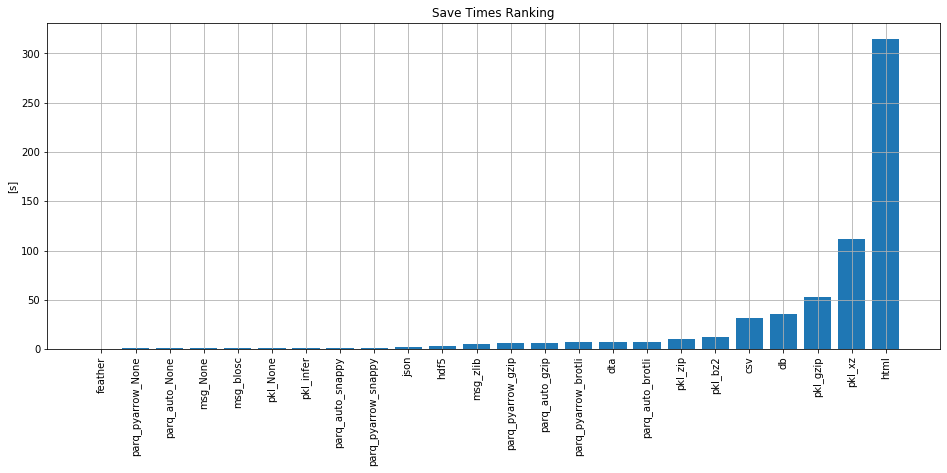

,Save Config,Time [s]
4,feather,0.417643
12,parq_pyarrow_None,0.719291
11,parq_auto_None,0.734454
15,msg_None,0.804921
14,msg_blosc,0.935159
22,pkl_None,1.255339
17,pkl_infer,1.258200
5,parq_auto_snappy,1.647200
6,parq_pyarrow_snappy,1.660218
1,json,2.528106


In [22]:
save_labels, save_times = [], []
for l, t in zip(get_labels([t.save_tag for t in test_cases]), [t.save_time for t in test_cases]):
    if l not in save_labels:
        save_labels.append(l)
        save_times.append(t)
        
df_save_info = pd.DataFrame.from_dict({"Save Config": save_labels, "Time [s]": save_times})

display(save_labels, save_times, "Save Times Ranking", "[s]")
df_save_info.sort_values(by="Time [s]").head(24)

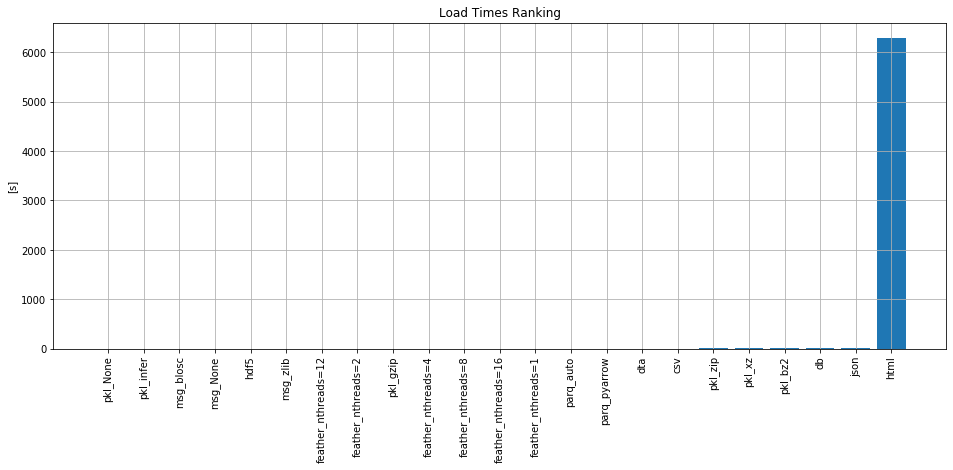

,Load Config,Time [s]
21,pkl_None,0.507254
16,pkl_infer,0.508675
13,msg_blosc,0.542115
14,msg_None,0.542746
3,hdf5,0.748186
12,msg_zlib,0.778492
8,feather_nthreads=12,1.000456
5,feather_nthreads=2,1.003231
17,pkl_gzip,1.007818
6,feather_nthreads=4,1.010194


In [23]:
load_labels, load_times = [], []
for l, s in zip(get_labels([t.load_tag for t in test_cases]), [t.load_time for t in test_cases]):
    if l not in load_labels:
        load_labels.append(l)
        load_times.append(s)
        
df_load_info = pd.DataFrame.from_dict({"Load Config": load_labels, "Time [s]": load_times})

display(load_labels, load_times, "Load Times Ranking", "[s]")
df_load_info.sort_values(by="Time [s]").head(24)

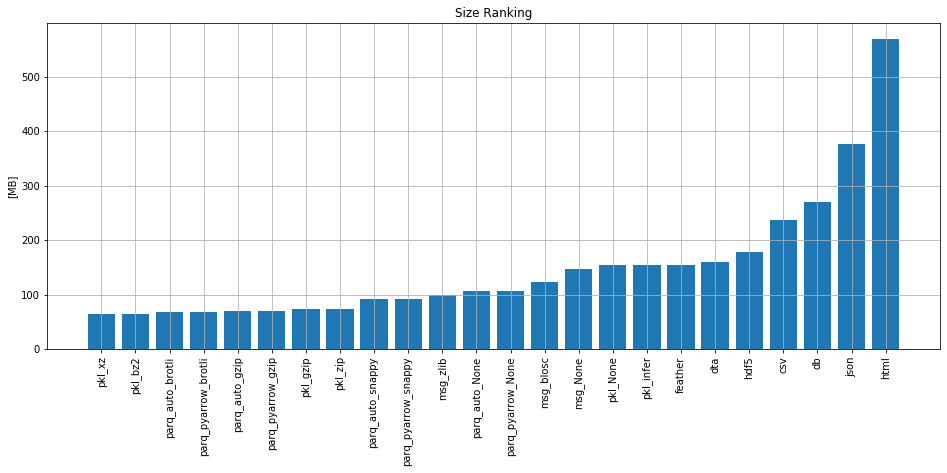

,Save Config,Size [MB]
21,pkl_xz,64.265625
19,pkl_bz2,64.295762
10,parq_pyarrow_brotli,68.424079
9,parq_auto_brotli,68.424079
7,parq_auto_gzip,69.352485
8,parq_pyarrow_gzip,69.352485
18,pkl_gzip,72.894416
20,pkl_zip,73.780753
5,parq_auto_snappy,91.626276
6,parq_pyarrow_snappy,91.626276


In [24]:
size_labels, sizes = [], []
for l, s in zip(get_labels([t.save_tag for t in test_cases]), [t.file_size for t in test_cases]):
    if l not in size_labels:
        size_labels.append(l)
        sizes.append(s)
        
df_size_info = pd.DataFrame.from_dict({"Save Config": size_labels, "Size [MB]": sizes})

display(size_labels, sizes, "Size Ranking", "[MB]")
df_size_info.sort_values(by="Size [MB]").head(24)